In [124]:
!pip install bokeh

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [125]:
!pip install folium

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [126]:
!pip install geopandas

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [142]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import geopandas
from IPython.display import IFrame

from bokeh.models.widgets import DataTable, TableColumn, RadioButtonGroup, Select
from bokeh.plotting import ColumnDataSource, figure, show
from bokeh.io import output_file, reset_output, output_notebook
from bokeh.models.widgets import Tabs, Panel, Div
from bokeh.models import Span, Range1d, CustomJS, TextInput, HoverTool
from bokeh.layouts import layout, row, column, widgetbox, gridplot
from bokeh.models import SingleIntervalTicker, LinearAxis, Label, Span
output_notebook()

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', -1)

Loading BokehJS ...

In [128]:
common_info = pd.read_csv('mosgaz-streets.csv')
rests = pd.read_csv('/datasets/rest_data.csv')

In [129]:
states = geopandas.read_file('mo.geojson', driver='GeoJSON')  # с границами Москвы

In [130]:
def create_bokeh_report(df, missingno=True, show_hists=True, 
                        table_width=500, table_height = 400, show_zeros=True):
    reset_output()
    output_notebook()
    
    df_name = [x for x in globals() if globals()[x] is df][0]

    df_height = df.shape[0]
    df_width = df.shape[1]
    
    if df_height > 30000:
        df = df[:30000]

    z = df.notnull().values
    g = np.zeros((df.shape[0], df.shape[1], 3))

    color = (0.25, 0.25, 0.25) # gray

    g[z < 0.5] = [255, 255, 255]
    g[z > 0.5] = color

    xdim, ydim = df.shape[1], df.shape[0]
    img = np.empty((ydim, xdim), dtype=np.uint32)
    view = img.view(dtype=np.uint8).reshape((ydim, xdim, 4))
    view[:,:,0] = g[:,:,0] # copy red channel
    view[:,:,1] = g[:,:,1] # copy blue channel
    view[:,:,2] = g[:,:,2] # copy green channel
    view[:,:,3] = 255 # Alpha
    
    img = img[::-1]
    NaNs = figure(title="NaNs count, %", x_range=(-2,1.2*xdim), y_range=(-ydim*0.2,1.3*ydim), 
                  width=table_width, height=400, tools='pan, wheel_zoom, reset')
    NaNs.image_rgba(image=[img], x=0, y=0, dw=xdim, dh=ydim)
    i_columns = 0.4
    for label in df.columns:
        label1, label2 = label, label
        count_nulls_perc = df[label].count()/len(df)
        if len(label1) > 15:
            text_label1_font_size = '8pt'
        elif len(label1) > 10:
            text_label1_font_size = '9pt'
        else:
            text_label1_font_size = '11pt'

        label1 = Label(x=[i_columns, i_columns + 0.1][len(label1)<7], y=[ydim*1.01, ydim*1.03][len(label1)<7], 
                       text=label1, text_font_size=text_label1_font_size, angle=3/4)
        NaNs.add_layout(label1)
        if show_zeros:
            label2 = Label(x=i_columns, y=-ydim*0.15, text='{:.2%}'.format(1-count_nulls_perc), 
                           text_font_size='10pt', angle=3/4)
            NaNs.add_layout(label2)
        elif 1-count_nulls_perc > 0:
            label2 = Label(x=i_columns, y=-ydim*0.15, text='{:.2%}'.format(1-count_nulls_perc), 
                           text_font_size='10pt', angle=3/4)
            NaNs.add_layout(label2)
        i_columns += 1
        
    y_min_label = Label(x=-0.1*xdim, y=-ydim*0.01, text='1', text_font_size='10pt')
    NaNs.add_layout(y_min_label)
    y_max_label = Label(x=-0.1*xdim-len(str(df_height))/25, y=ydim*1.01, text='{}'.format(df_height), 
                        text_font_size='10pt')
    NaNs.add_layout(y_max_label)
    
    # vertical white lines to separate columns from each other
    for column_count in range(1, len(df.columns)):
        line = NaNs.line([column_count, column_count], [0, ydim], color='white')
        NaNs.add_layout(line)
    
    NaNs.xaxis.visible = None
    NaNs.yaxis.visible = None
    NaNs.xgrid.grid_line_color = None
    NaNs.ygrid.grid_line_color = None
    NaNs.outline_line_alpha = 0 
    
    # выбор отображения датафрейма
    
    mask = df.isnull().any(axis=1)
    df_NaNs = df[mask][:30]
    df_no_NaNs = df[~mask][30:60]
    source_df = ColumnDataSource(data=df.sample(30))
    source_NaNs = ColumnDataSource(data=df_NaNs)
    source_no_NaNs = ColumnDataSource(data=df_no_NaNs)
    source_full_df = ColumnDataSource(data=df)
    source_fill = ColumnDataSource(data=df.sample(30))
    
    select = Select(title='Dataframe to show:', value='Sample(30)', 
                    options=["Sample(30)", "Rows with NaNs", "Rows w/o NaNs", "Full_df"], width=150)
    
    update = CustomJS(args=dict(source_fill=source_fill, source_df=source_df, source_NaNs=source_NaNs,
        source_no_NaNs=source_no_NaNs, source_full_df=source_full_df), code="""

    var f = cb_obj.value;

    if (f == 'Sample(30)') {
        source_fill.data = source_df.data;
    }
    if (f == 'Rows with NaNs') {
        source_fill.data = source_NaNs.data;
    }
    if (f == 'Rows w/o NaNs') {
        source_fill.data = source_no_NaNs.data;
    }
    if (f == 'Full_df') {
        source_fill.data = source_full_df.data;
    }

    source_fill.change.emit();
    """)
    
    select.js_on_change('value', update)
    
    div_common = Div(text="""DataFrame <b>"{dfname}"</b> consists of <b>{shape0} rows</b> 
                             and <b>{shape1} columns</b>.<br/>
                             It has <b>{NaNs} NaNs</b>.""".format(dfname = df_name, shape0 = df_height, 
                                                                  shape1 = df_width, NaNs = df.isnull().sum().sum()),
                                                                  width=200, height=100)
    
    df_describe = df.describe(include='all')
    df_describe = df_describe.fillna('')
    df_describe = df_describe.drop(['count', 'top', 'freq'], axis=0)
    curr_rows = df_describe.index.values
    df_describe.loc['type', :] = 1
    df_describe.loc['NaNs, %', :] = 1
    for column_count in range(len(df_describe.columns)):
        df_describe.iloc[-2, column_count] = df.iloc[:,column_count].dtype.name
        df_describe.iloc[-1, column_count] = '{:.2f}'.format(1 - len(df.iloc[:,column_count])/
                                                             df.iloc[:,column_count].count())

    df_describe = df_describe.reindex([df_describe.index.values[-2], df_describe.index.values[-1], *curr_rows])
    
    div_info = Div(text="""{dfinfo}""".format(dfinfo = df_describe.to_html()),
    width=200, height=100)

    radio_button_group = RadioButtonGroup(labels=["Sample(30)", "Rows with NaNs", "Rows w/o NaNs", "Full df"], active=1)
    radio_button_group.js_on_change('active', update)
    
    # сама таблица
    Columns = [TableColumn(field=column, title=column) for column in df.columns]
    data_table = DataTable(columns=Columns, source=source_fill, width=table_width, height=table_height,
                           selectable=False) 
    
    # виджет текста
    widgets_layout = column(Div(), row(Div(), div_common, spacing=-160), spacing=85)
    
    # гистограммы
    if show_hists:
        int_columns = df._get_numeric_data().columns.to_list()
        hists = ['hist' + str(x+1) for x in range(len(int_columns))]
        hists_for_layout = []
        for i in range(len(int_columns)):
            series_to_plot = df[int_columns[i]]
            measured = series_to_plot.values
            hist, edges = np.histogram(measured, density=True, bins=300)
            hists[i] = figure(title='Histogram of {}'.format(int_columns[i]), plot_width = 400, plot_height=300,
                              tools='pan, zoom_in, reset', background_fill_color="#fafafa")
            hist_plot = hists[i].quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
               fill_color="navy", line_color="white", alpha=0.5)
            hists[i].y_range.start = 0
            hists[i].xaxis.axis_label = 'x'
            hists[i].yaxis.axis_label = 'Pr(x)'
            hists[i].grid.grid_line_color="white"
            right = series_to_plot.quantile(0.99)
            hists[i].x_range=Range1d(0, right)
            hists_for_layout.append(hists[i])
    
    l1 = layout([[data_table, select, widgets_layout]])
    l2 = layout([[NaNs]])
    l3 = layout([[div_info]])
    if show_hists:
        l4 = layout([[*hists_for_layout]])
    
    tabs = list()
    tab1 = Panel(child=l1, title=df_name)
    tab2 = Panel(child=l2, title='NaNs')
    tab3 = Panel(child=l3, title='Info')
    tabs.append(tab1)
    tabs.append(tab2)
    tabs.append(tab3)
    if show_hists:
        tab4 = Panel(child=l4, title='Histograms')
        tabs.append(tab4)
    
    tabs = Tabs(tabs=tabs)

    show(row(tabs))


# функция чтобы скрыть ячейку   
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Показать/скрыть ячейку'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [101]:
create_bokeh_report(rests, table_width=750)

Loading BokehJS ...

In [131]:
# подгружаем токен
from yaml import safe_load

with open('config_Geocoder.yaml') as file:
    token_source = safe_load(file)
    
token_Geocoder = token_source['Yandex Maps']['token']

In [16]:
# запускаем функцию
import requests as r
url = 'https://geocode-maps.yandex.ru/1.x/?format=json&apikey={}&geocode='.format(token_Geocoder)
coordinates = []
i = 0
for rest_address in rests['address']:
    if rest_address == rest_address: # чтоб не столкнуться с nan
        url_formatted = url + 'Москва, ' + rest_address
        response = r.get(url_formatted).json()
        try:
            data = response['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point'].get('pos')
        except:
            pass
        if data is not None:
            coordinate = (float(data.split()[1]), float(data.split()[0]))
            coordinates.append(coordinate)
        else:
            coordinates.append('')
    else:
        coordinates.append('')

In [132]:
rests = pd.read_csv('rest_data_coordinates.csv')
rests = rests.drop(rests.columns[:2], axis=1)

In [133]:
rests.head(10)

id               object_name chain object_type  \
0  151635  СМЕТАНА                   нет   кафе         
1  77874   Родник                    нет   кафе         
2  24309   Кафе «Академия»           нет   кафе         
3  21894   ПИЦЦЕТОРИЯ                да    кафе         
4  119365  Кафе «Вишневая метель»    нет   кафе         
5  27429   СТОЛ. ПРИ ГОУ СОШ № 1051  нет   столовая     
6  148815  Брусника                  да    кафе         
7  20957   Буфет МТУСИ               нет   столовая     
8  20958   КПФ СЕМЬЯ-1               нет   столовая     
9  28858   Столовая МТУСИ            нет   столовая     

                                               address  number  \
0  город Москва, улица Егора Абакумова, дом 9           48       
1  город Москва, улица Талалихина, дом 2/1, корпус 1    35       
2  город Москва, Абельмановская улица, дом 6            95       
3  город Москва, Абрамцевская улица, дом 1              40       
4  город Москва, Абрамцевская улица, дом 9, корпус 1    50       
5  город Москва, Абрамцевская улица, дом 15, корпус 1   240      
6  город Москва, переулок Сивцев Вражек, дом 6/2        10       
7  город Москва, Авиамоторная улица, дом 8, строение 1  90       
8  город Москва, Авиамоторная улица, дом 8, строение 1  150      
9  город Москва, Авиамоторная улица, дом 8, строение 1  120      

              coordinates  
0  (55.879005, 37.714474)  
1  (55.738307, 37.673295)  
2  (55.735571, 37.669576)  
3  (55.892713, 37.573007)  
4  (55.904074, 37.572279)  
5  (55.906744, 37.571525)  
6  (55.747388, 37.598043)  
7  (55.754882, 37.715471)  
8  (55.754882, 37.715471)  
9  (55.754882, 37.715471)

In [134]:
rests['Latitude'] = rests['coordinates'].apply(lambda x: float(x.split(',')[0].lstrip('(')))
rests['Longitude'] = rests['coordinates'].apply(lambda x: float(x.split(',')[1].rstrip(')')))
rests['count'] = 1

In [135]:
import folium
from folium.plugins import HeatMap
from folium import plugins


base_map = folium.Map(location=[55.753215, 37.622504], control_scale=False, zoom_start=9)

data = rests[['Latitude', 'Longitude', 'count']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist()
HeatMap(data=data, radius=10, max_zoom=5, 
        blur=14, max_val=15).add_to(base_map)

base_map

In [136]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [137]:
def get_state(row):
    try:
        return states[states['geometry'].contains(Point(row.Longitude, row.Latitude))]['NAME'].values[0]
    except:
        return np.NaN
    
rests['state'] = rests.apply(get_state, axis=1)

In [138]:
rests[rests.state.isnull()]

id     object_name chain object_type  \
7437  74990  Кафе «Сахара»   нет   кафе         
7438  71261  Кафе «Загорье»  нет   кафе         
7783  23762  Столовая        нет   столовая     

                                                                      address  \
7437  город Москва, 26-й километр Московской Кольцевой Автодороги, владение 6   
7438  город Москва, 28-й километр Московской Кольцевой Автодороги, владение 7   
7783  город Москва, Интернациональная улица, дом 10                             

      number             coordinates   Latitude  Longitude  count state  
7437  50      (55.582217, 37.706865)  55.582217  37.706865  1      NaN   
7438  48      (55.582217, 37.706865)  55.582217  37.706865  1      NaN   
7783  200     (55.945509, 37.330525)  55.945509  37.330525  1      NaN

In [111]:
rests_gr = rests.groupby('state')['id'].count().reset_index()

In [140]:
rests_gr

state   id
0    "Мосрентген"   18 
1    Академический  126
2    Алексеевский   128
3    Алтуфьевский   32 
4    Арбат          271
..     ...          ...
141  Южное Тушино   115
142  Южнопортовый   120
143  Якиманка       191
144  Ярославский    100
145  Ясенево        110

[146 rows x 2 columns]

In [141]:
states = states.merge(rests_gr, left_on="NAME", right_on="state")

In [146]:
m = folium.Map(location=[55.753215, 37.622504], zoom_start=10)

bins = [1, 10, 60, 100, 200, 350, 600, 850]

folium.Choropleth(
    geo_data=states,
    name='choropleth',
    data=rests_gr,
    columns=['state', 'id'],
    key_on='feature.properties.NAME',
    fill_color='YlGnBu',
    fill_opacity=0.8,
    line_opacity=0.4,
    bins=bins
).add_to(m)

style_function = lambda x: {
    'fillColor': 'ffffff',
    'color': 'black',
    'weight': 0,
    'fillOpacity': 0
}

stategeo = folium.GeoJson(
    states1,
    name='Districts',
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['NAME', 'NAME_AO', 'id'],
        aliases=['Район', 'Округ', 'Кол-во ресторанов'], 
        localize=False
    ),
    smooth_factor = 0
).add_to(m)

statesearch = Search(
    layer=stategeo,
    geom_type='Polygon',
    placeholder='Search for a district',
    collapsed=False,
    search_label='NAME',
    weight=3
).add_to(m)

folium.LayerControl().add_to(m)

IFrame('index.html', width='100%', height='750px')

In [13]:
plt.style.use('seaborn-pastel')

Исследуйте соотношение видов объектов общественного питания по количеству. Постройте график

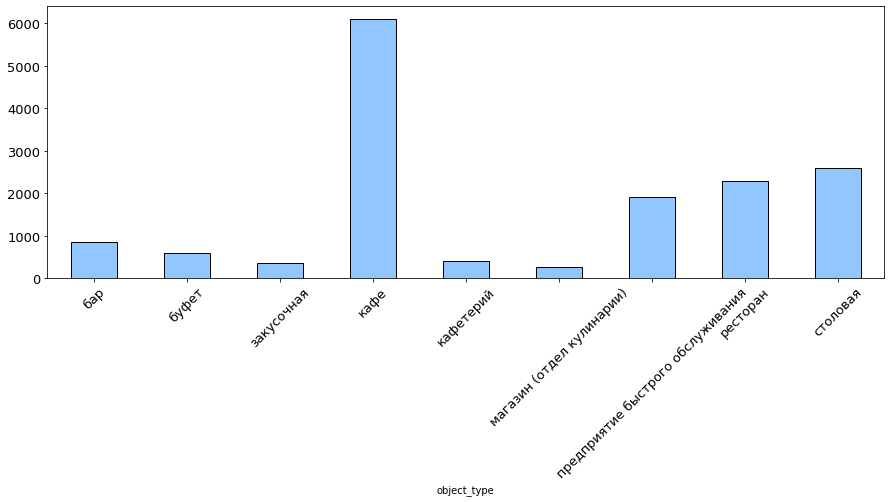

In [17]:
rests.groupby('object_type')['id'].count().plot(kind='bar', rot=45, figsize=(15,5), 
                                                ec='black', fontsize=13)

Исследуйте соотношение сетевых и несетевых заведений по количеству. Постройте график.

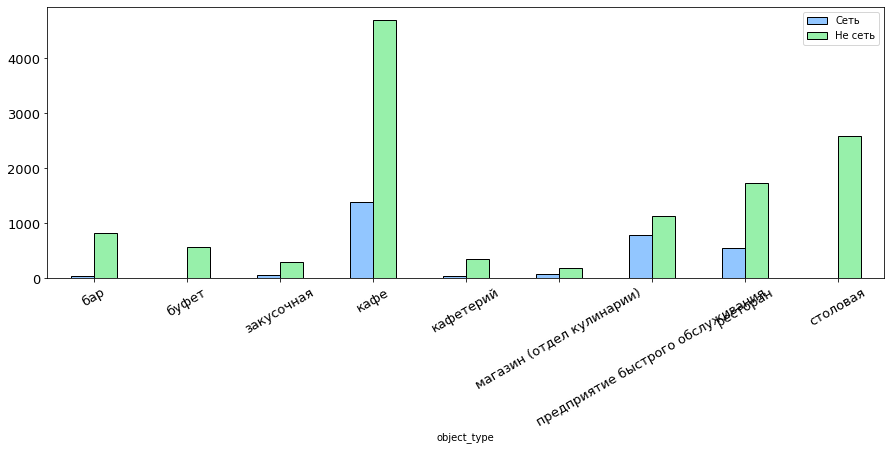

In [25]:
rests.groupby('object_type')['chain'].agg([
                                         ('Сеть', lambda x: sum(x == 'да')),
                                         ('Не сеть', lambda x: sum(x == 'нет'))                                           
                                         ]).plot(kind='bar', figsize=(15,5), rot=30, 
                                                 ec='black', fontsize=13)

Для какого вида объекта общественного питания характерно сетевое распространение?

Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

In [57]:
rests.query('chain == "да"').groupby('object_name')['id'].count().sort_values(ascending=False)

object_name
KFC                    155
Шоколадница            141
Бургер Кинг            122
Макдоналдс             122
Домино'с Пицца         86 
                       .. 
Мираторг               1  
Молли гвинз            1  
Му-му                  1  
Мюнгер                 1  
Beverly Hills Diner    1  
Name: id, Length: 724, dtype: int64

In [46]:
import folium
from folium.plugins import HeatMap

base_map = folium.Map(location=[55.753215, 37.622504], control_scale=False, zoom_start=9)

data = (rests.query('chain == "да"')[['Latitude', 'Longitude', 'count']]
                    .groupby(['Latitude', 'Longitude']).sum()
                    .reset_index().values.tolist()
       )
HeatMap(data=data, radius=10, max_zoom=5, 
        blur=10, max_val=15).add_to(base_map)


base_map